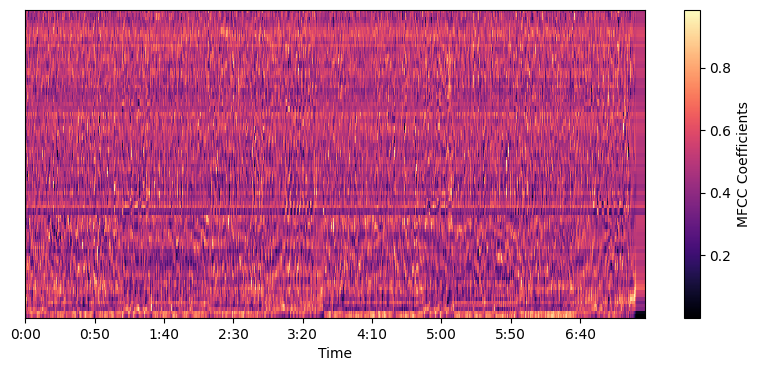

In [19]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.ndimage import median_filter
from sklearn.preprocessing import MinMaxScaler
import librosa
import numpy as np

# Load file âm thanh
y, sr = librosa.load("../Data/MusicNet_Dataset/musicnet/musicnet/train_data/1727.wav", sr=44100)

hop_length = int(0.03125 * sr)
# Áp dụng STFT để chuyển sang miền tần số
D = librosa.stft(y, n_fft=2048, hop_length=hop_length)
magnitude, phase = np.abs(D), np.angle(D)

# Ước lượng nhiễu từ các frame đầu tiên (giả sử 0.5 giây đầu là nhiễu)
num_noise_frames = int(0.5 * sr / hop_length)  
noise_estimate = np.mean(magnitude[:, :num_noise_frames], axis=1, keepdims=True)

# Trừ nhiễu (Spectral Subtraction)
magnitude_denoised = np.maximum(magnitude - noise_estimate, 0)

# Chuyển về miền thời gian
D_denoised = magnitude_denoised * np.exp(1j * phase)
y_denoised = librosa.istft(D_denoised, hop_length=hop_length)

# Trích xuất MFCC từ tín hiệu đã khử nhiễu
mfcc = librosa.feature.mfcc(y=y_denoised, sr=sr, n_mfcc=30, hop_length=hop_length)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

# Chuẩn hóa từng phần riêng biệt
scaler = MinMaxScaler()
mfcc_scaled = scaler.fit_transform(mfcc.T).T
mfcc_delta_scaled = scaler.fit_transform(mfcc_delta.T).T
mfcc_delta2_scaled = scaler.fit_transform(mfcc_delta2.T).T

# Kết hợp lại
mfcc_combined = np.vstack([mfcc_scaled, mfcc_delta_scaled, mfcc_delta2_scaled])
mfcc_combined = np.clip(mfcc_combined, 0, 1)

from scipy.ndimage import gaussian_filter
mfcc_smoothed = gaussian_filter(mfcc_combined, sigma=0.5)

# Vẽ lại biểu đồ
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_smoothed, x_axis="time", sr=sr, hop_length=hop_length, cmap="magma")
plt.colorbar(label="MFCC Coefficients")
plt.show()

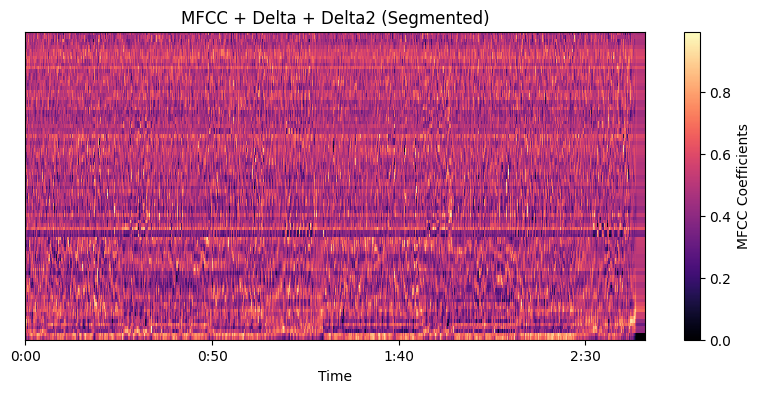

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import librosa


# Định nghĩa độ dài đoạn (số khung MFCC trên mỗi đoạn)
segment_length = 3  # Khoảng 0.03125 giây

# Số đoạn có thể cắt
num_segments = mfcc_combined.shape[1] // segment_length

# Chia MFCC thành các đoạn và lấy trung bình từng đoạn
mfcc_segmented = np.array([
    np.mean(mfcc_combined[:, i * segment_length : (i + 1) * segment_length], axis=1)
    for i in range(num_segments)
]).T  # Chuyển về dạng (features, time)

# Vẽ lại biểu đồ sau khi chia nhỏ
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_segmented, x_axis="time", sr=sr, hop_length=512 * segment_length, cmap="magma")
plt.colorbar(label="MFCC Coefficients")
plt.title("MFCC + Delta + Delta2 (Segmented)")
plt.show()